**Prereqs**

List all the modules needed to run the below notebook.

Authors:
Project Description:
Who built what?
Analysis

**Import Modules**

In [152]:
import pandas as pd
import sqlite3
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import json
import plotly.express as px
from datetime import datetime
import folium
from folium.plugins import HeatMap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC


**Read in the wildfire dataset and display columns**

- Download dataset from https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires/data
- unzip into /data directory

In [153]:
# # extract the zipped dataset
with zipfile.ZipFile('./data/archive.zip', 'r') as zipped:
    zipped.extractall('./data/')

In [154]:
# connect to the sqlite database
conn = sqlite3.connect('data/FPA_FOD_20170508.sqlite')

In [155]:
tables = pd.read_sql_query(
    """
    SELECT name FROM sqlite_master WHERE type='table'
    """
    , conn)

In [156]:
# Print out the table names
tables

,name
0,spatial_ref_sys
1,spatialite_history
2,sqlite_sequence
3,geometry_columns
4,spatial_ref_sys_aux
5,views_geometry_columns
6,virts_geometry_columns
7,geometry_columns_statistics
8,views_geometry_columns_statistics
9,virts_geometry_columns_statistics


**Utilizing Fires Table**

In [157]:
# read in the fires table
wildfireDf = pd.read_sql_query(
    """
    SELECT * 
    FROM fires
    """
    , conn)

**Exploratory Data Analysis**
Display the first 5 rows

In [158]:
wildfireDf.head(5)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [159]:
# Describe the dataset
wildfireDf.describe

<bound method NDFrame.describe of          OBJECTID     FOD_ID             FPA_ID SOURCE_SYSTEM_TYPE  \
0               1          1         FS-1418826                FED   
1               2          2         FS-1418827                FED   
2               3          3         FS-1418835                FED   
3               4          4         FS-1418845                FED   
4               5          5         FS-1418847                FED   
...           ...        ...                ...                ...   
1880460   1880461  300348363  2015CAIRS29019636             NONFED   
1880461   1880462  300348373  2015CAIRS29217935             NONFED   
1880462   1880463  300348375  2015CAIRS28364460             NONFED   
1880463   1880464  300348377  2015CAIRS29218079             NONFED   
1880464   1880465  300348399  2015CAIRS26733926             NONFED   

        SOURCE_SYSTEM NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  \
0         FS-FIRESTAT                    FS            

In [160]:
wildfireDf.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [161]:
#dropping duplicates
wildfireAnalysisDf = wildfireDf.drop_duplicates()

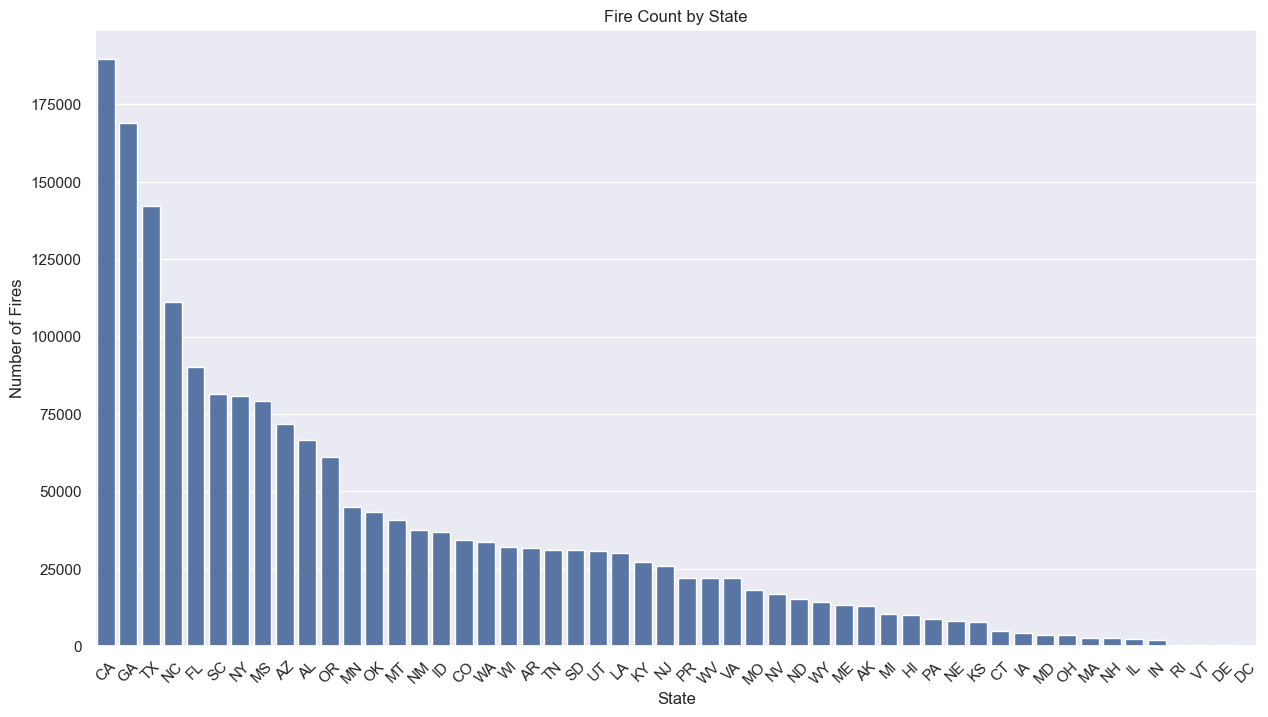

In [162]:
#TODO: Rajeev
#Visualize fire count by state

# Assuming wildfireAnalysisDf is your DataFrame
fire_count_by_state = wildfireAnalysisDf.groupby('STATE').size().sort_values(ascending=False)

plt.figure(figsize=(15, 8))
sns.barplot(x=fire_count_by_state.index, y=fire_count_by_state.values)
plt.xlabel('State')
plt.ylabel('Number of Fires')
plt.title('Fire Count by State')
plt.xticks(rotation=45)
plt.show()

In [163]:
# Connor
# Find wildfire count by county
countyDf = wildfireAnalysisDf.groupby("STATE").size().to_frame('Count').sort_values(by=["Count"], ascending=False).reset_index()
countyDf.head()

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)


fig = px.choropleth(countyDf, locations='STATE', color='Count',
    locationmode="USA-states",
    color_continuous_scale="Reds",
    scope="usa",
    labels={'Count':'Wildfire Count'},
    title="Wildfire Count By State"
)
fig.show()

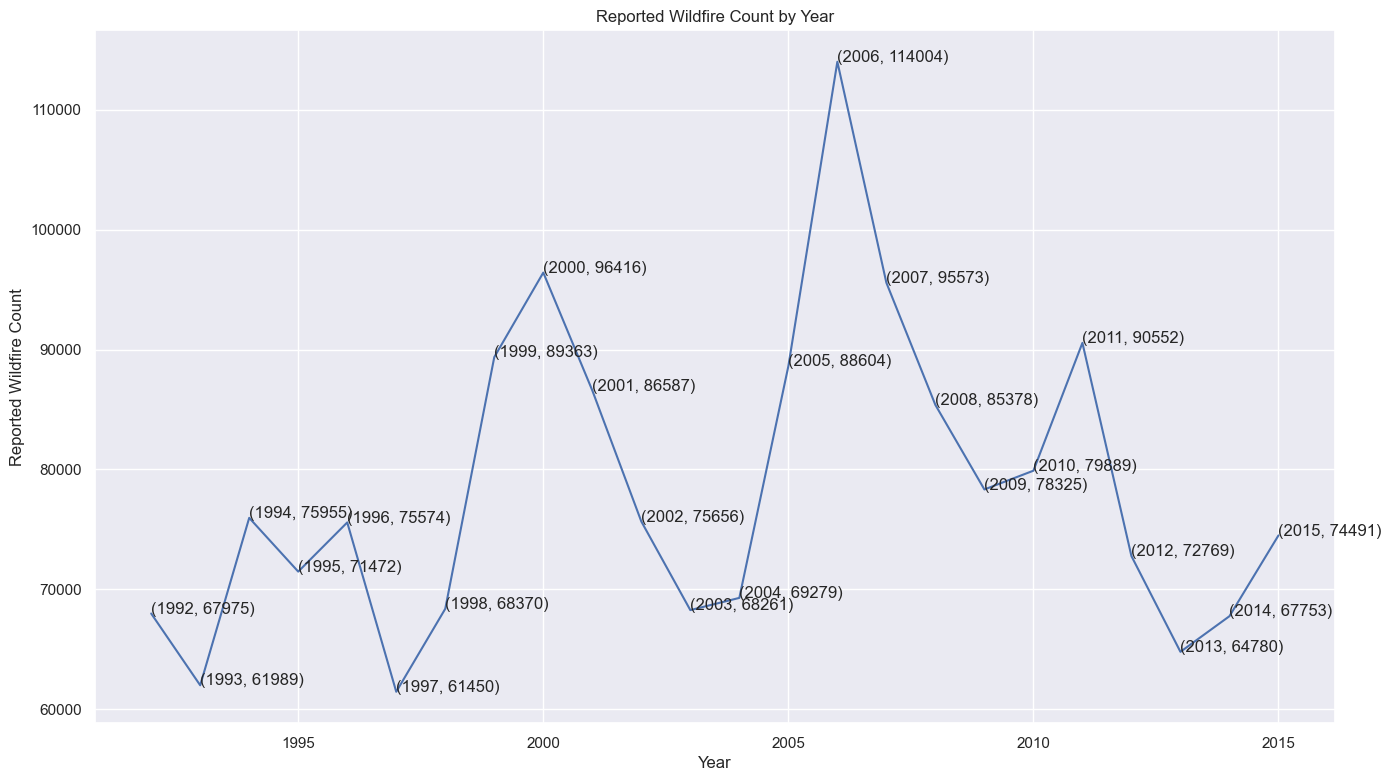

In [164]:
#TODO: Connor
#Visualize fire count over time
firesOverTimeDf = wildfireAnalysisDf.groupby("FIRE_YEAR").size().to_frame('Count').reset_index()
# create plot
fig, ax = plt.subplots(figsize =(16, 9))
ax.plot(firesOverTimeDf["FIRE_YEAR"],firesOverTimeDf["Count"])
plt.xlabel("Year")
plt.ylabel("Reported Wildfire Count")
plt.title("Reported Wildfire Count by Year")
# add annotation to points
for (i, j) in zip(firesOverTimeDf["FIRE_YEAR"],firesOverTimeDf["Count"]):
    plt.text(i, j, f'({i}, {j})')

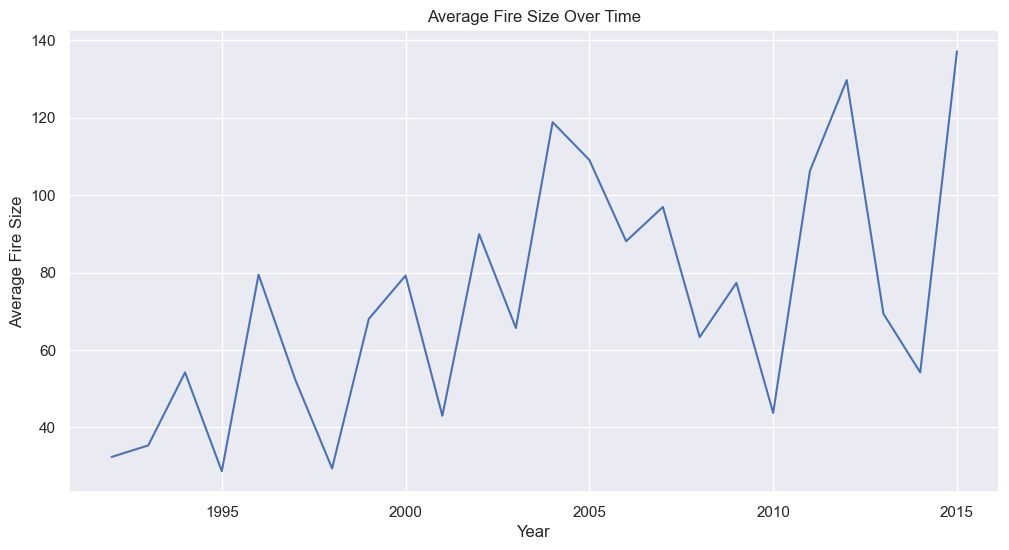

In [165]:
#TODO: Naveen
#Visualize avg fire size over time
# Group the data by 'FIRE_YEAR' and calculate the average fire size for each year
avg_fire_size_per_year = wildfireAnalysisDf.groupby('FIRE_YEAR')['FIRE_SIZE'].mean()

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_fire_size_per_year.index, y=avg_fire_size_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average Fire Size')
plt.title('Average Fire Size Over Time')

# Display the plot
plt.show()

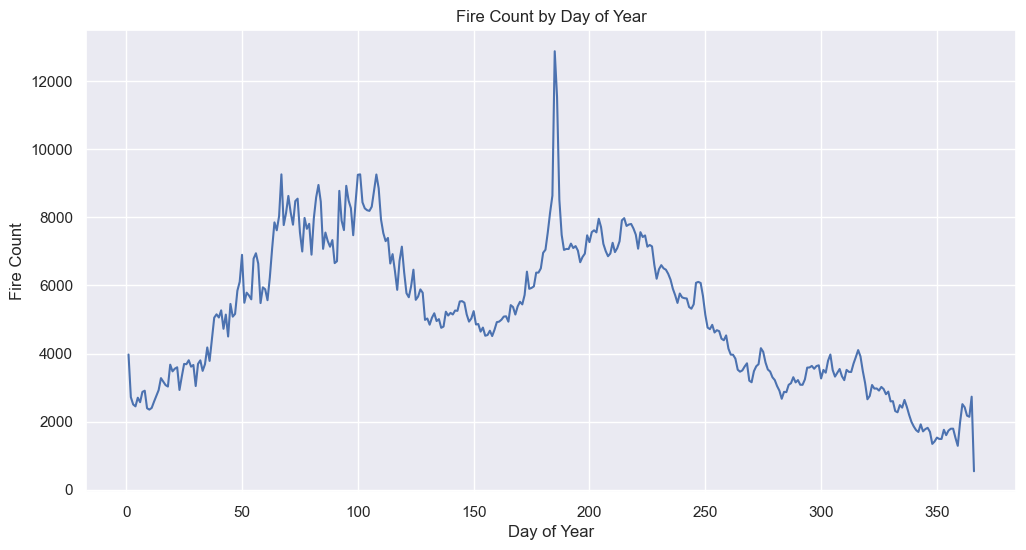

In [166]:
#TODO: Rajeev
#Plot fire count by DISCOVERY_DOY, or DISCOVERY_DATE

# For plotting fire count by DISCOVERY_DOY
fire_count_by_doy = wildfireAnalysisDf.groupby('DISCOVERY_DOY').size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=fire_count_by_doy.index, y=fire_count_by_doy.values)
plt.xlabel('Day of Year')
plt.ylabel('Fire Count')
plt.title('Fire Count by Day of Year')
plt.show()

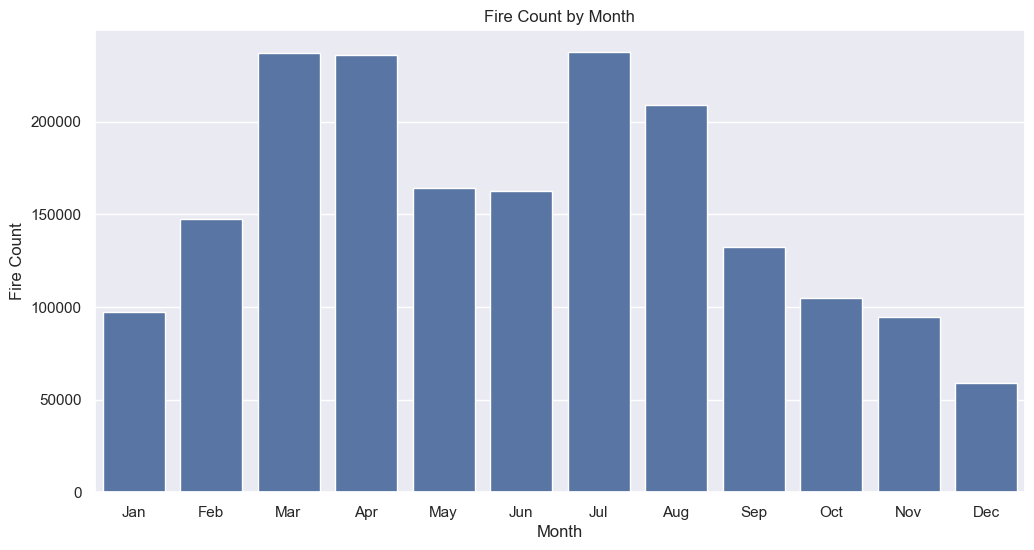

In [167]:
#Rajeev
# This script first converts the day of the year to the corresponding month
# and then plots the count of fires per month. The plot will provide a clear view of the monthly distribution of wildfire occurrences.

# Function to convert day of the year to month
def doy_to_month(doy):
    # Using a non-leap year for conversion (e.g., 2021)
    date = datetime.strptime(f'2021-{doy}', '%Y-%j')
    return date.strftime('%b')  # %b gives the abbreviated month name

# Apply the conversion to the DISCOVERY_DOY column
wildfireAnalysisDf['DISCOVERY_MONTH'] = wildfireAnalysisDf['DISCOVERY_DOY'].apply(doy_to_month)

# Group by the new DISCOVERY_MONTH column and count the fires
fire_count_by_month = wildfireAnalysisDf.groupby('DISCOVERY_MONTH').size()

# Ordering the months correctly
months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fire_count_by_month = fire_count_by_month.reindex(months_order)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=fire_count_by_month.index, y=fire_count_by_month.values)
plt.xlabel('Month')
plt.ylabel('Fire Count')
plt.title('Fire Count by Month')
plt.show()

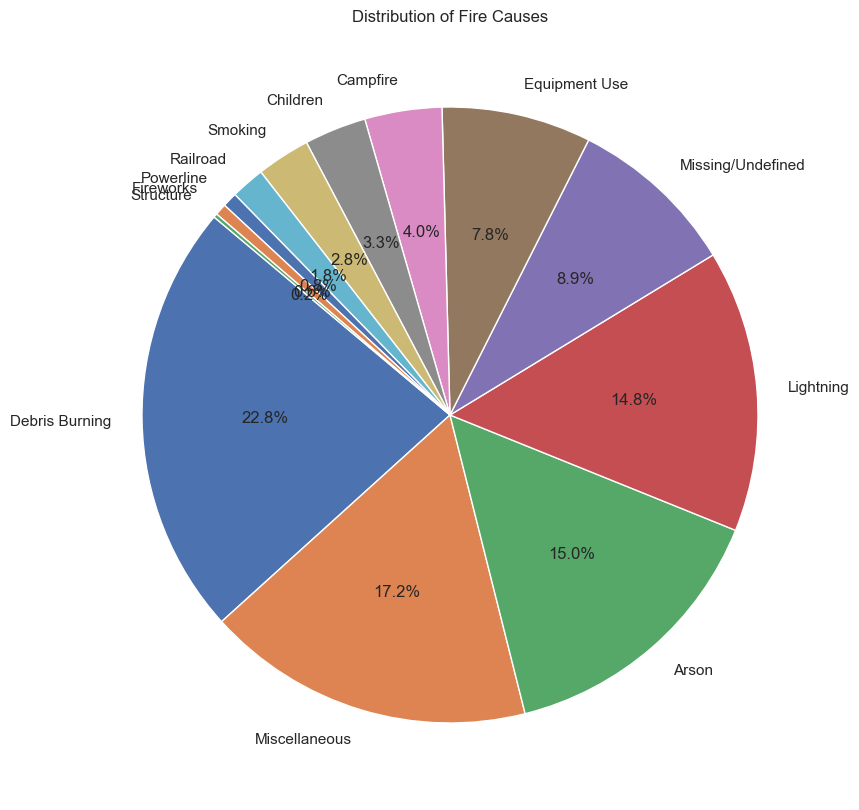

In [168]:
#TODO: Rajeev
# Fire Causes Distribution
fire_causes = wildfireAnalysisDf['STAT_CAUSE_DESCR'].value_counts()

plt.figure(figsize=(10, 10))
plt.pie(fire_causes, labels=fire_causes.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Fire Causes')
plt.show()

In [169]:
#TODO: Naveen
#Create a new column of duration of fire (CONT_DOY-DISCOVERY_DOY)

wildfireAnalysisDf['FIRE_DURATION'] = wildfireAnalysisDf['CONT_DOY'] - wildfireAnalysisDf['DISCOVERY_DOY']

# Handle cases where the fire spans over the new year
wildfireAnalysisDf['FIRE_DURATION'] = wildfireAnalysisDf['FIRE_DURATION'].apply(lambda x: x if x >= 0 else x + 365)

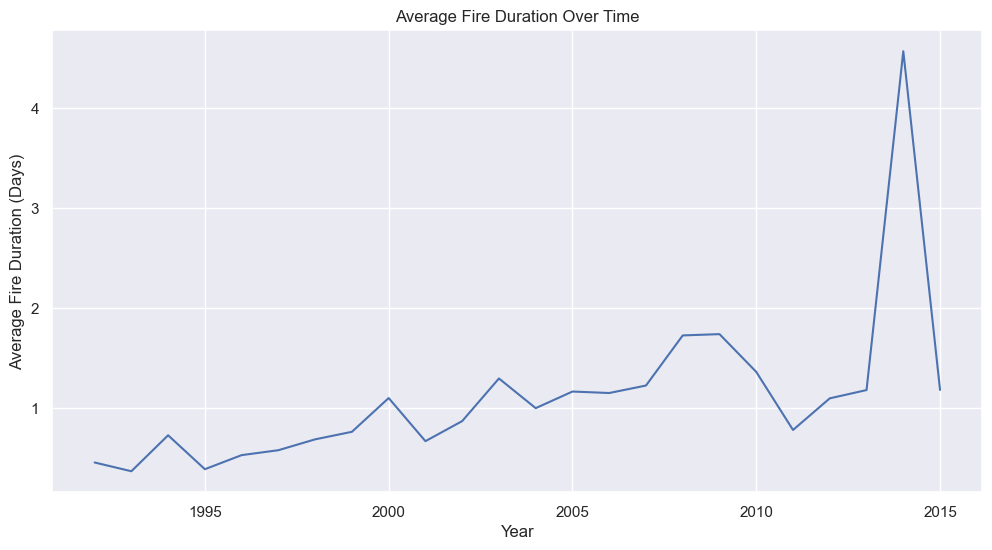

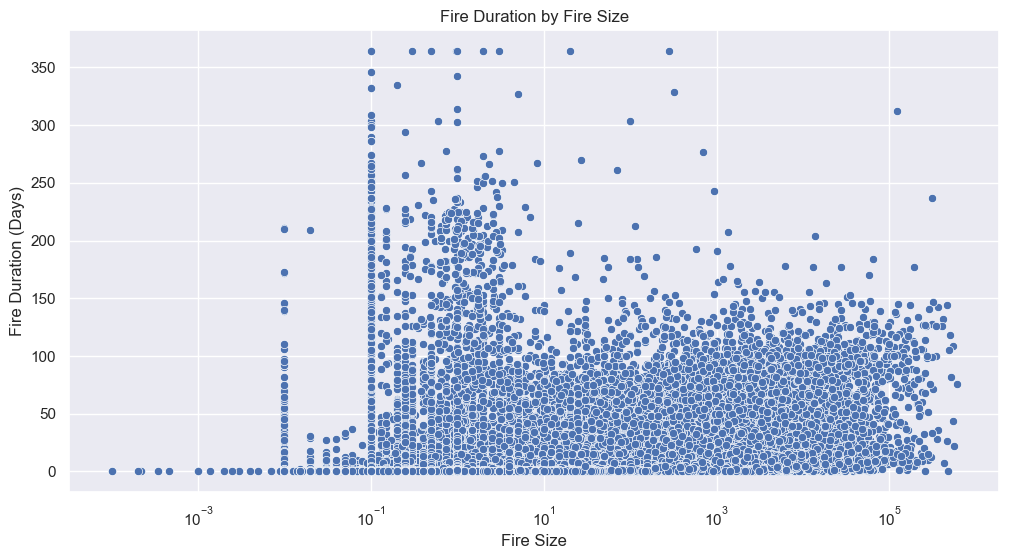

In [170]:
#TODO: Naveen
#Plot Duration by time
#Plot duration by Fire_Size


# Group by FIRE_YEAR and calculate the average fire duration for each year
avg_duration_per_year = wildfireAnalysisDf.groupby('FIRE_YEAR')['FIRE_DURATION'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_duration_per_year.index, y=avg_duration_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average Fire Duration (Days)')
plt.title('Average Fire Duration Over Time')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='FIRE_SIZE', y='FIRE_DURATION', data=wildfireAnalysisDf)
plt.xlabel('Fire Size')
plt.ylabel('Fire Duration (Days)')
plt.title('Fire Duration by Fire Size')
plt.xscale('log')  # Optional: Use logarithmic scale if fire sizes vary widely
plt.show()

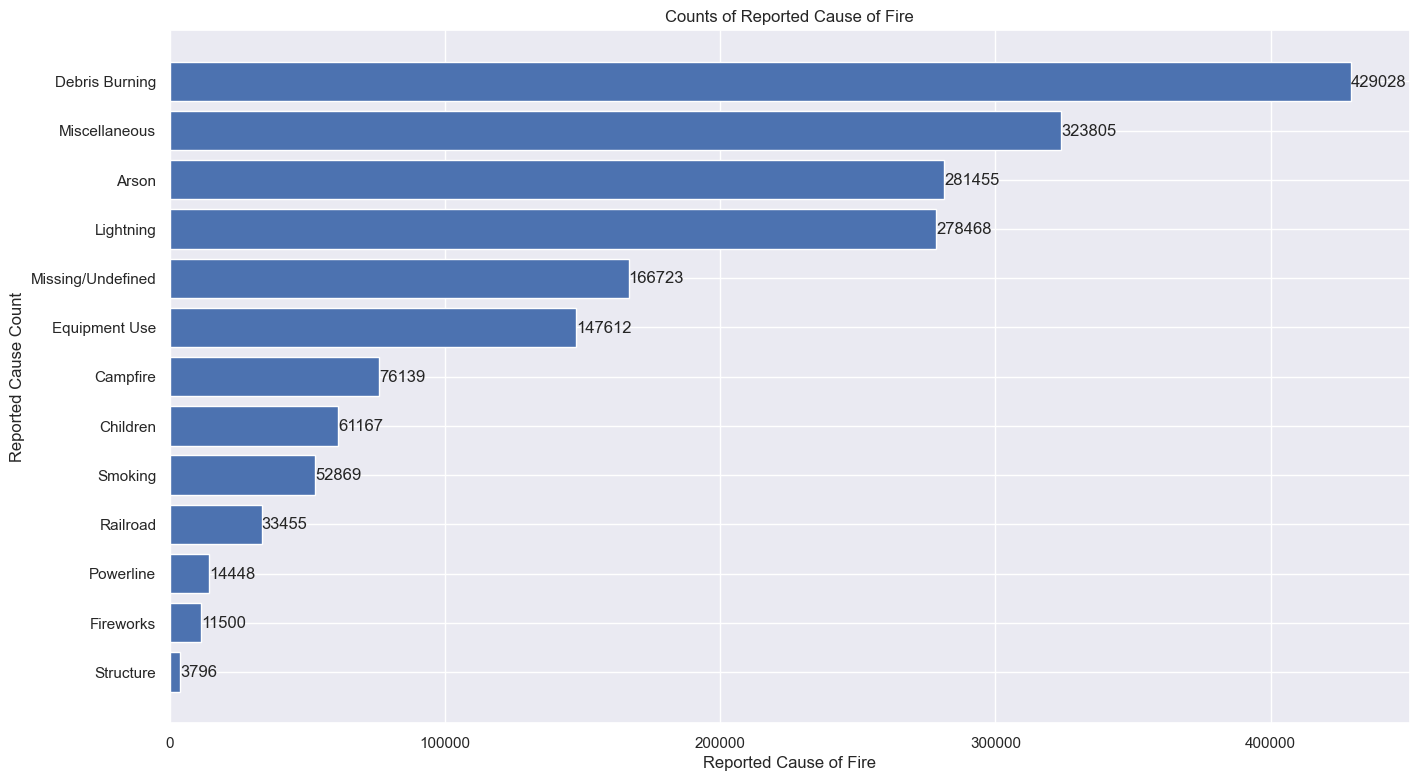

In [171]:
#TODO: Connor
#Visualize fire count by STAT_CAUSE_CODE/desc (cause), label with description
fireCausesDf = wildfireAnalysisDf.groupby("STAT_CAUSE_DESCR").size().to_frame('Count').sort_values(by=["Count"], ascending=False).reset_index()
# create plot
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(fireCausesDf["STAT_CAUSE_DESCR"],fireCausesDf["Count"])
# add title and labels
plt.xlabel("Reported Cause of Fire")
plt.ylabel("Reported Cause Count")
plt.title("Counts of Reported Cause of Fire")
# invert order so highest first
plt.gca().invert_yaxis()
# add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
        str(round((i.get_width()), 2)))

In [172]:
# Creating a copy of the DataFrame
wildfire_df_copy = wildfireAnalysisDf.copy()

# Selecting relevant columns
relevant_columns = ['FIRE_YEAR', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'STATE', 'DISCOVERY_MONTH', 'FIRE_DURATION', 'STAT_CAUSE_DESCR']
wildfire_df_selected = wildfire_df_copy[relevant_columns]


In [173]:

# Handling missing values
wildfire_df_selected = wildfire_df_selected.dropna()

# Converting categorical variables to dummy variables
wildfire_df_processed = pd.get_dummies(wildfire_df_selected, columns=['OWNER_CODE', 'STATE', 'DISCOVERY_MONTH'])


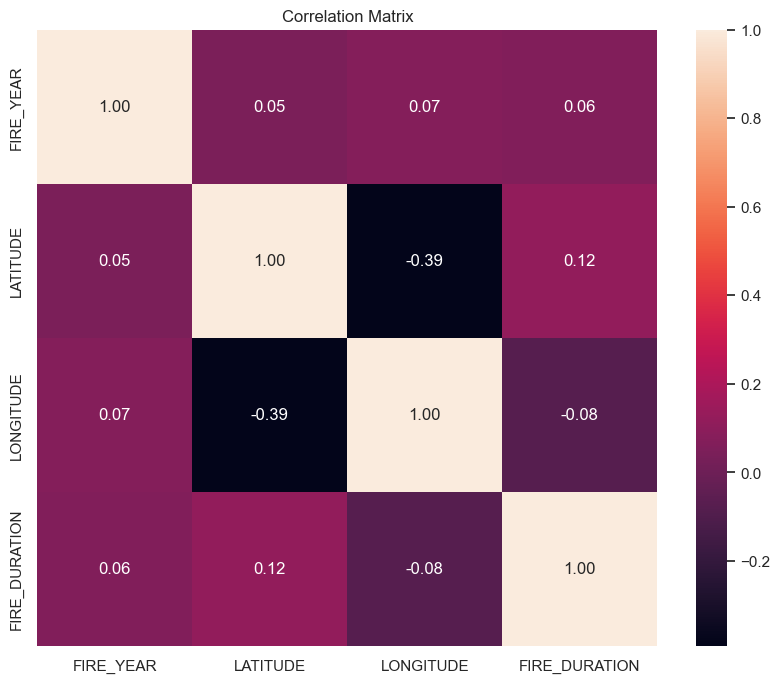

In [174]:
# Exclude non-numeric columns for correlation calculation
numeric_df = wildfire_df_processed.select_dtypes(include=[np.number])

# Calculate the correlation matrix for numeric columns only
corr_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [175]:
# Splitting the data into features (X) and target (y)
X = wildfire_df_processed.drop('STAT_CAUSE_DESCR', axis=1)
y = wildfire_df_processed['STAT_CAUSE_DESCR']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


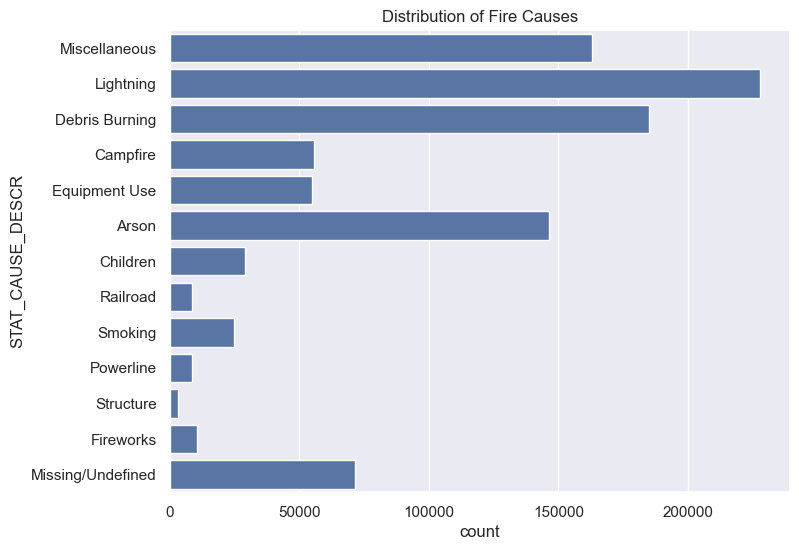

In [176]:
# Visualize the distribution of target variable
sns.countplot(y)
plt.title("Distribution of Fire Causes")
plt.show()

In [177]:
# Randomly sample a subset of your data, for example, 10% of it
sampled_df = wildfire_df_processed.sample(frac=0.1, random_state=42)

# Split the sampled data into features and target
X_sampled = sampled_df.drop('STAT_CAUSE_DESCR', axis=1)
y_sampled = sampled_df['STAT_CAUSE_DESCR']

# Split into training and testing sets
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled, y_sampled, test_size=0.3, random_state=42)


In [178]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the training and testing sets
X_train_scaled = scaler.fit_transform(X_train_sampled)
X_test_scaled = scaler.transform(X_test_sampled)    

In [179]:
# Initialize the logistic regression model with a higher number of iterations
logistic_model_sampled = LogisticRegression(max_iter=2000)

# Fit the model on the scaled training data
logistic_model_sampled.fit(X_train_scaled, y_train_sampled)

LogisticRegression(max_iter=2000)

Accuracy on Scaled Test Data: 0.5309761359040043


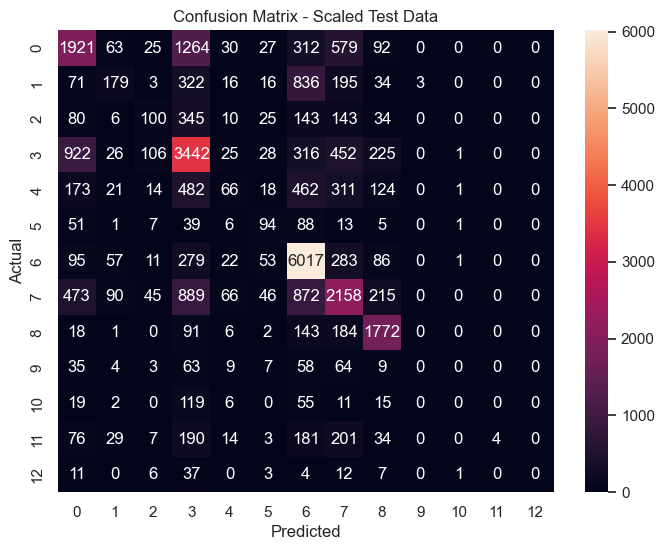

In [180]:
# Predict on the scaled test data
y_pred_sampled = logistic_model_sampled.predict(X_test_scaled)

# Evaluate the model
accuracy_sampled = accuracy_score(y_test_sampled, y_pred_sampled)
conf_matrix_sampled = confusion_matrix(y_test_sampled, y_pred_sampled)

# Display the accuracy and confusion matrix
print(f"Accuracy on Scaled Test Data: {accuracy_sampled}")
sns.heatmap(conf_matrix_sampled, annot=True, fmt="g")
plt.title("Confusion Matrix - Scaled Test Data")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Linear Regression Preprocessing

We are going to see if we are able to train a Linear Regression model to predict FIRE_SIZE, a continuous variable representing the size of the fire in acres.

In [217]:

# Connor - Linear Regression

# Objective: Train a linear regression model to predict the size of a wildfire (continuous variable FIRE_SIZE).

# Data Preprocessing:

# Address any missing or outlier values in FIRE_SIZE and other relevant features.
TARGET = "FIRE_SIZE"
SEED = 42
wildfireSizeAnalysisDf = wildfireAnalysisDf[["FIRE_SIZE", "FIRE_YEAR", "OWNER_CODE", "STAT_CAUSE_DESCR", "LATITUDE", "LONGITUDE", "STATE", "FIRE_DURATION","DISCOVERY_DOY"]]
wildfireSizeAnalysisDf = wildfireSizeAnalysisDf.dropna(axis=0)
wildfireSizeAnalysisDf.drop_duplicates(inplace=True)
wildfireSizeAnalysisDf = wildfireSizeAnalysisDf.astype({"STAT_CAUSE_DESCR":"string", "OWNER_CODE": "string"})
numericalFeatures = wildfireSizeAnalysisDf[["FIRE_SIZE","FIRE_YEAR", "LATITUDE", "LONGITUDE", "FIRE_DURATION", "DISCOVERY_DOY"]]

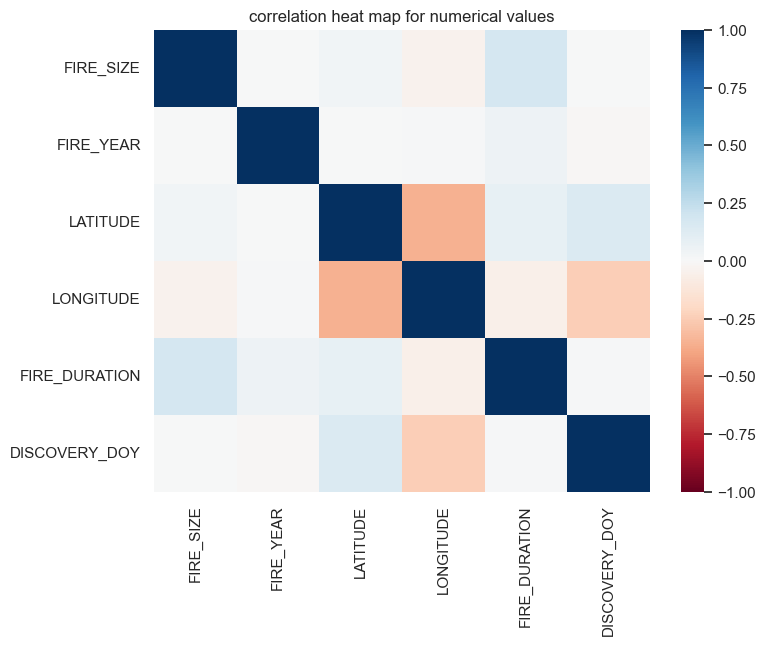

In [218]:
# Look at the correlation matrix
corr_mat = numericalFeatures.corr()
plt.title("correlation heat map for numerical values")
sns.set(rc={'figure.figsize':(8,6)})
s = sns.heatmap(corr_mat,cmap="RdBu",center=0,vmin=-1, vmax=1)

Linear Regression

In [219]:
# Let's try a model with only numerical data
scaler = StandardScaler()

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(numericalFeatures.drop(columns=[TARGET]),numericalFeatures[TARGET],test_size=.2,random_state=SEED)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a linear regression model on the training set.
linReg = LinearRegression()
linReg.fit(X_train, y_train)

yPred = linReg.predict(X_test)

# Evaluate the model's performance using metrics like R-squared, RMSE (Root Mean Squared Error).
linRegScore = r2_score(y_test,yPred)
linRegRMSE = mean_squared_error(y_test, yPred, squared=True)
print(f"R2 score: {linRegScore} \nRMSE: {linRegRMSE}")
 
# The R2 and RMSE scores are not promising for predicting wildfire size. 
# Let's see if including one-hot encoded variables helps

R2 score: 0.025667121940842863 
RMSE: 7159755.375284318


Text(0.5, 1.0, 'Linear Regression with Numerical Data Only, Predicted vs Actual')

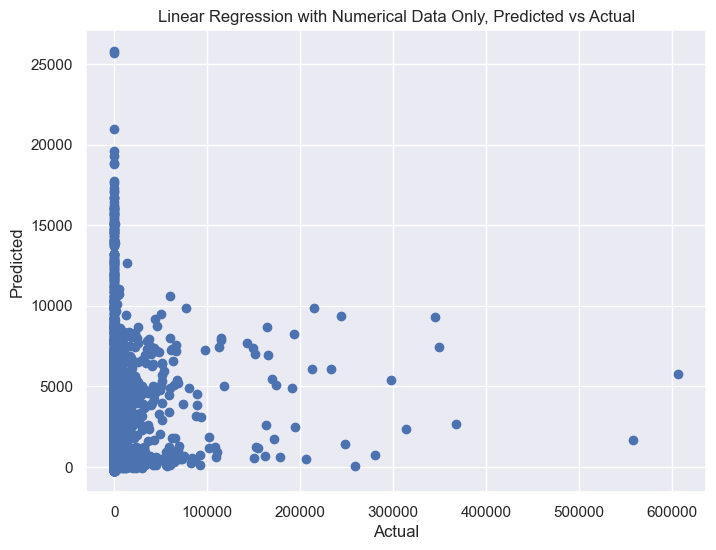

In [220]:
# visualize linear regression ran with numerical data only
plt.scatter(y_test, yPred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression with Numerical Data Only, Predicted vs Actual")
# This is not a very linear relationship, linear or random forest regression is not a choice model for predicting wildfires.

Linear Regression including one-hot encoded categorical features

In [221]:
# Convert categorical data to numerical format using encoding methods.
wildfireSizeAnalysisDf = pd.get_dummies(wildfireSizeAnalysisDf, columns = ["STATE","STAT_CAUSE_DESCR", "OWNER_CODE"])

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(wildfireSizeAnalysisDf.drop(columns=[TARGET]),wildfireSizeAnalysisDf[TARGET],test_size=.2,random_state=SEED)


In [222]:

# Train a linear regression model on the training set.
linReg = LinearRegression()
linReg.fit(X_train, y_train)

yPred = linReg.predict(X_test)

# Evaluate the model's performance using metrics like R-squared, RMSE (Root Mean Squared Error).
linRegScore = r2_score(y_test,yPred)
linRegRMSE = mean_squared_error(y_test, yPred, squared=True)
print(f"R2 score: {linRegScore} \nRMSE: {linRegRMSE}")

# This shows some improvement in test scores, but it is still not promising.


R2 score: 0.03130996631012051 
RMSE: 7118289.685051934


Text(0.5, 1.0, 'Linear Regression Predicted vs Actual')

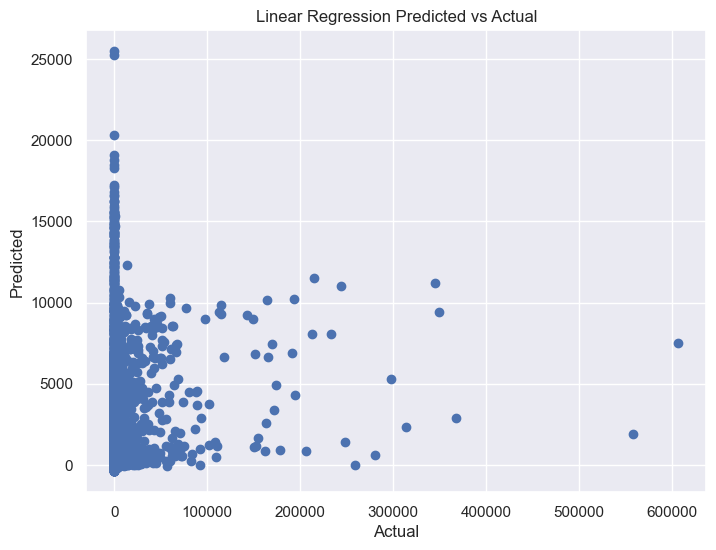

In [223]:
# visualize linear regression test results
plt.scatter(y_test, yPred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression Predicted vs Actual")
# This is not a very linear relationship, linear or random forest regression is not a choice model for predicting wildfires.

Random Forest Regression

In [224]:
#Try random forest regression!
#NOTE expect this cell to run for ~2 minutes!

#limit sample to 10,000 for time's sake
reg_rf = RandomForestRegressor(random_state=42, max_samples=10000)
reg_rf.fit(X_train,y_train)
y_pred = reg_rf.predict(X_test)

rRegScore=r2_score(y_test, y_pred)
rRegRMSE = mean_squared_error(y_test, yPred, squared=True)
print(f"R2 score: {rRegScore} \nRMSE: {rRegRMSE}")

R2 score: 0.0927841280577324 
RMSE: 7118289.685051934


Text(0.5, 1.0, 'Random Forest Regression Predicted vs Actual')

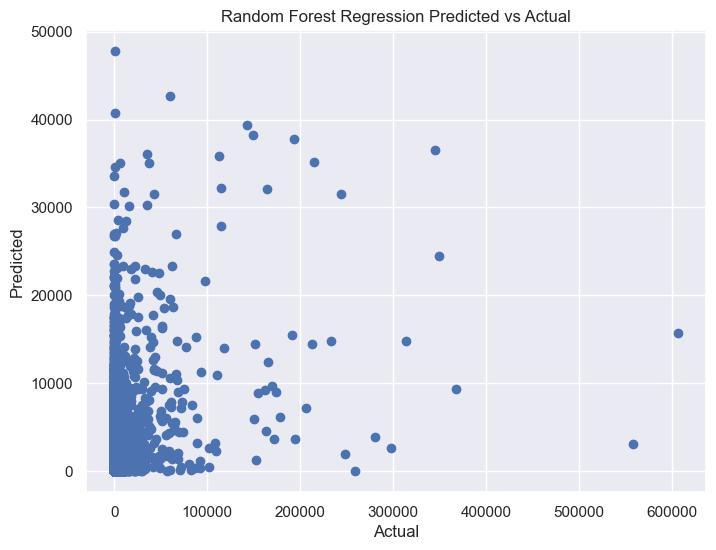

In [225]:
# visualize random forest regression results
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Regression Predicted vs Actual")
# This shows some improvement over linear regression, however it is still not promising as it is not showing a pattern. Random forest regression is not a choice model for predicting wildfires.

Linear Regression Conclusion:

From the results above, for linear regression we see that linear regression is not sufficient to create a predictive model with the features "FIRE_YEAR", "OWNER_CODE", "STAT_CAUSE_DESCR", "LATITUDE", "LONGITUDE", "STATE", "FIRE_DURATION","DISCOVERY_DOY" to predict "FIRE_SIZE". 

Ultimately, the R2, RMSE scores are too low and Prediction vs. Actual plots show us that this does not make a trustworthy model of predicting fire size. In the Prediction vs. Actual plot we would like to see a direct linear trend with some variation and there is no direct relationship apparent.

Random Forest Regression offered some improvement in model performance. Further increasing the sampling size in random forest did not achieve meaningful increases in model accuracy at the expense of compute resources. Therefore it was deemed not necessary to run a long training with this model. The level of accuracy of this model, seen with the R2, RMSE, and Prediction vs. Actual plot also do not offer promising scores or a direct trend in the graph.

In order to improve model performance, we suggest further feature acquisition, particularly features related to weather. Joining wildfire data by county with weather data such as precipitation and wind speed and direction may improve the performance of this predictive model and offer more useful information.

**PCA**

In [226]:
features = wildfireAnalysisDf[['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'STAT_CAUSE_CODE']]
target = wildfireAnalysisDf['FIRE_DURATION']

# Handling missing values
features.fillna(features.mean(), inplace=True)
target.fillna(target.mean(), inplace=True)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


C:\Users\Connor McColl\AppData\Local\Temp\ipykernel_12832\2910105226.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



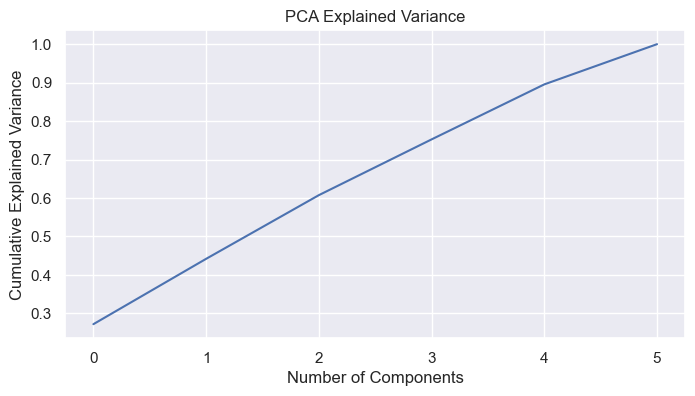

In [227]:
# Applying PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Plotting the Explained Variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()


In [228]:
# Choosing a specific number of components
n_components = 5
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [229]:
#function to train and evaluate the Decision Tree model
def train_evaluate_decision_tree(X_train, y_train, X_test, y_test):
    dt_reg = DecisionTreeRegressor(max_depth=6)
    dt_reg.fit(X_train, y_train)
    y_pred = dt_reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return dt_reg, mse, r2

# Train Decision Tree on original scaled data
dt_reg_original, mse_dt_original, r2_dt_original = train_evaluate_decision_tree(X_train_scaled, y_train, X_test_scaled, y_test)

# Train Decision Tree on PCA-transformed data
dt_reg_pca, mse_dt_pca, r2_dt_pca = train_evaluate_decision_tree(X_train_pca, y_train, X_test_pca, y_test)

# Print Metrics
print("Decision Tree Regression on Original Data - MSE:", mse_dt_original, "R2 Score:", r2_dt_original)
print("Decision Tree Regression on PCA Data - MSE:", mse_dt_pca, "R2 Score:", r2_dt_pca)


Decision Tree Regression on Original Data - MSE: 31.38788608535016 R2 Score: 0.17722680882968478
Decision Tree Regression on PCA Data - MSE: 34.06300749339848 R2 Score: 0.10710363546009505


<Figure size 1000x500 with 0 Axes>

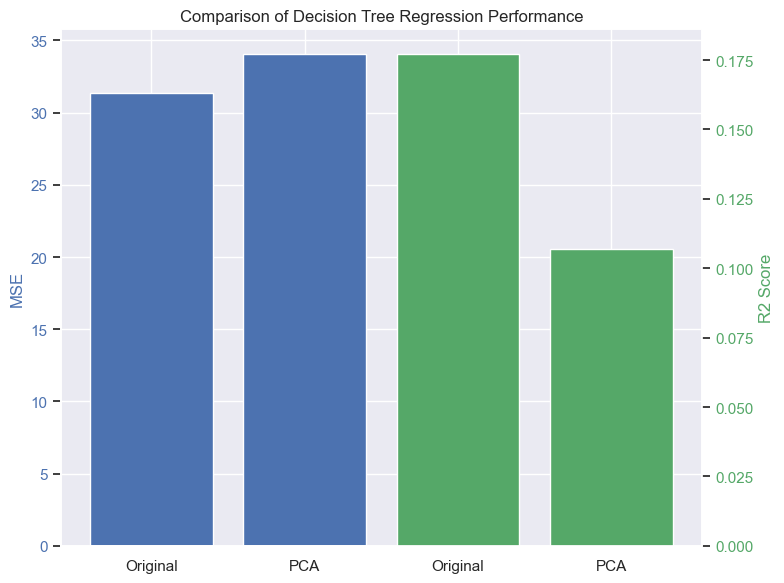

In [230]:
# Plotting the comparison
fig = plt.figure(figsize=(10, 5))
fig, ax1 = plt.subplots()
bar_width = 0.35
index = np.arange(2)
mse_scores = [mse_dt_original, mse_dt_pca]
r2_scores = [r2_dt_original, r2_dt_pca]

bar1 = ax1.bar(index, mse_scores, label='MSE', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylabel('MSE', color='b')
ax2=ax1.twinx()
ax2.grid(False)
bar2 = ax2.bar(index+2, r2_scores, label='R2 Score', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylabel('R2 Score', color='g')
plt.title('Comparison of Decision Tree Regression Performance')
plt.xticks(np.arange(4),['Original', 'PCA','Original','PCA'])

plt.tight_layout()
plt.show()

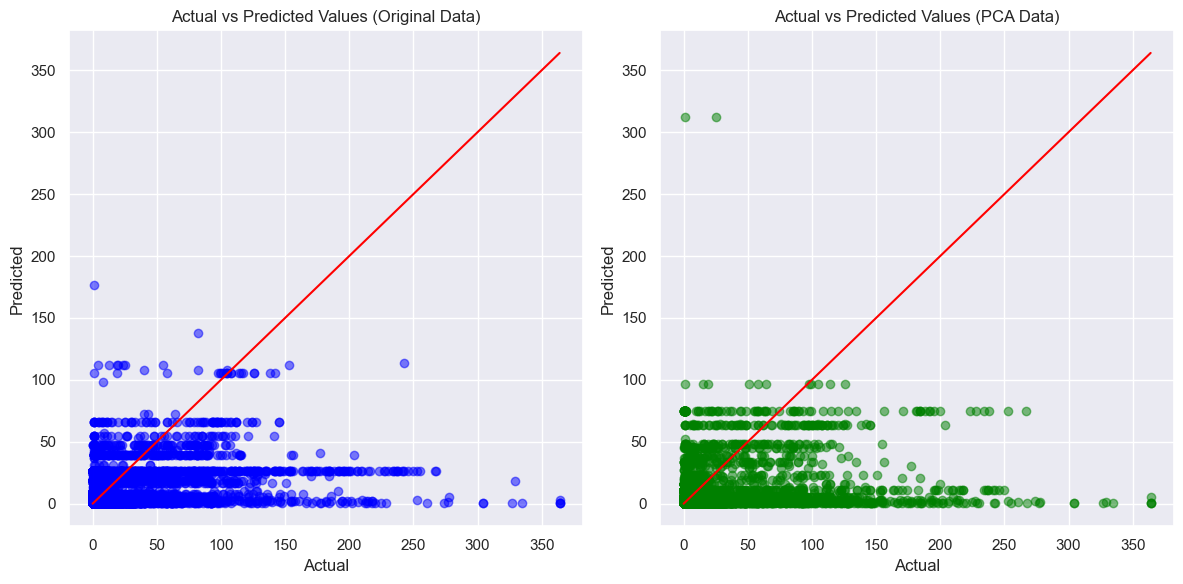

In [242]:
# Plotting the comparison
plt.figure(figsize=(12, 6))

y_pred_original = dt_reg_original.predict(X_test_scaled)
# Scatter plot for original data
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_original, alpha=0.5, color='blue')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Original Data)')
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], color='red')

# Scatter plot for PCA data
plt.subplot(1, 2, 2)
y_pred_pca = dt_reg_pca.predict(X_test_pca)
plt.scatter(y_test, y_pred_pca, alpha=0.5, color='green')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (PCA Data)')
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], color='red')

plt.tight_layout()
plt.show()


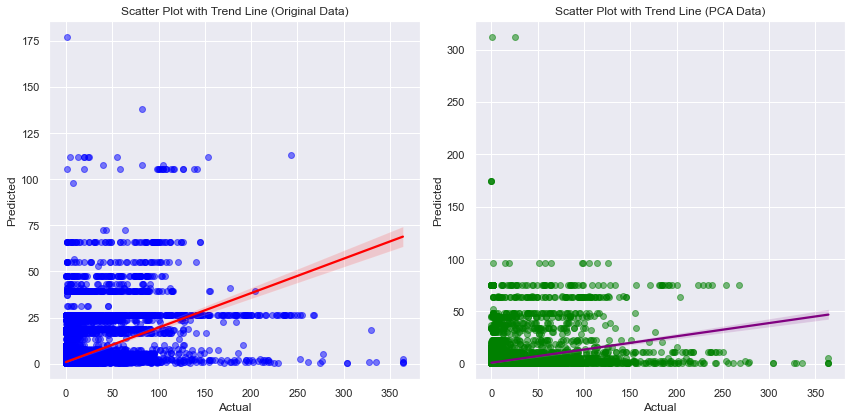

In [ ]:
# Scatter plot with trend line for original data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.regplot(x=y_test, y=y_pred_original, scatter_kws={'alpha':0.5, 'color':'blue'}, line_kws={'color':'red'})
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot with Trend Line (Original Data)')

# Scatter plot with trend line for PCA data
plt.subplot(1, 2, 2)
sns.regplot(x=y_test, y=y_pred_pca, scatter_kws={'alpha':0.5, 'color':'green'}, line_kws={'color':'purple'})
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot with Trend Line (PCA Data)')

plt.tight_layout()
plt.show()

**CONCLUSION**

*Lets conclude the project*